In [2]:
from os import listdir
from os.path import isfile
from fnmatch import fnmatch
from math import isnan, ceil
from pprint import pprint
from statistics import median
from re import match, split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties

In [3]:
def get_ratio(filename, mw=False):
    i = 0
    if mw:
        i = 1
    return filename.split('_')[i].replace('ratio','')

In [4]:
def get_run(filename, mw=False):
    i = 1
    if mw:
        i = 2
    return int(filename.split('_')[i].replace('run',''))

In [5]:
def get_vcs(filename, mw=False):
    i = 2
    if mw:
        i = 3
    return int(filename.split('_')[i].replace('vclients',''))

In [6]:
def get_worker_threads(filename, mw=False):
    i = 3
    if mw:
        i = 4 
        return int(filename.split('_')[i].replace('workerthreads', '').replace('.log', ''))
    return int(filename.split('_')[i].replace('workerthreads', ''))

In [7]:
def get_client(filename):
    return int(filename.split('_')[4].replace('client', ''))

In [8]:
def get_instance(filename):
    return int(filename.split('_')[-1].replace('instance','').replace('.log', ''))

In [9]:
def get_mw(filename):
    return int(filename.split('_')[0].replace('stats', ''))

In [10]:
def roundup(x):
    return int(ceil(x / 1.0)) * 1

In [11]:
def parse_mt_content(path, filename):
    secs_pat = '\[RUN #1 \d+%,\s+(\d+) secs'
    SECS = 70.0
    GET_TOTAL = 0.0
    SET_TOTAL = 0.0
    approx_rt = []
    percent = 0.0

    with (open(path+filename, 'r')) as file:
        for line in file.readlines():
            m = match(secs_pat, line)
            if line.startswith('Sets'):
                m = match("Sets\s+(\d+.\d+)", line)
                SET_TOTAL = SECS * float(m.group(1))
            elif line.startswith('Gets'):
                m = match("Gets\s+(\d+.\d+)", line)
                GET_TOTAL = SECS * float(m.group(1))
            elif line.startswith('GET'):
                m = match("GET\s+(\d+.\d+)\s+(\d+.\d+)", line)
                count = (float(m.group(2)) - percent) / 100.0 * GET_TOTAL
                percent = float(m.group(2))
                approx_rt.extend([float(m.group(1))] * int(count))
    throughput = (SET_TOTAL + GET_TOTAL) / SECS
    return approx_rt, throughput 

In [12]:
def parse_mw_content(path, filename, GET_TOTAL):
    SECS = 70.0
    approx_rt = []

    with (open(path+filename, 'r')) as file:
        for line in file.readlines():
            if line.startswith('GET'):
                m = match("GET,\s+(\d+.\d+),\s+(\d+)\n", line)
                count = (float(m.group(2))) / 100.0 * GET_TOTAL
                approx_rt.extend([float(m.group(1))] * int(count))
    return approx_rt

In [13]:
def dump_csv(df, filename):
    df.to_csv(filename, float_format='%.2f')
    return

In [14]:
def get_avg_rt(df, ratios, worker_threads, vclients, runs, threads, instances, clients):
    plt.ioff() 
    rts = []
    ils = []
    system = 'mw' if len(df.columns) < 7 else 'mt'
    fig, ax = plt.subplots()
    width = 20
    base = 5
    separator = 2
    prev = base
    xticks = []
    xticklabels = []
    for j, ratio in enumerate(ratios):
        mget = ratio.split(':')[-1]
        whole = []
        cols = ['ResponseTime (ms)', '25', '50', '75', '90', '99']
        values = []
        stds = []
        xs = []
        il = []
        
        if system == 'mt':
            for i, col in enumerate(cols):
                values.append(df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.mean().unstack().T.mean().mean())
                stds.append(np.std(df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.mean().unstack().T.mean()))
                il.append((1 / values[i]) * 1000 * (vclients[0] * threads * instances * clients))
            
                x = int(prev + width + separator)
                xs.append(x)
                prev = x
        else:
            col = 'ResponseTime (ms)'
            values.append(df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.mean().mean())
            stds.append(np.std(df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.mean()))
            jobs =  df.loc[(ratio, worker_threads[0], vclients[0]), 'Jobs'].T.sum().mean() / 70.0 / 1000 * df.loc[(ratio, worker_threads[0], vclients[0]), 'ResponseTime (ms)'].unstack().T.mean().mean() 
            il.append((1 / df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.mean().mean()) * 1000 * (jobs / clients))
            x = int(prev + width + separator)
            xs.append(x)
            prev = x
                
            
        ils.extend(il)
            
        prev += width
        
        xticks.extend(xs)
        cols[0] = 'AVG RT'
        xticklabels.extend(cols)
        
        bs = plt.bar(xs, values, width, yerr=stds)
        
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_axisbelow(True)
    
    plt.grid(b=True, which='major', axis='y', color='0.65', linestyle='dotted')
    plt.ylabel("Response Time (msec)")
    plt.legend(labels=['%d KEYs' % x for x in [1, 3, 6, 9]], frameon=False, loc='top', ncol=2)
    if system == 'mt':
        title = 'MEMTIER'
    else:
        plt.close(fig) 
        return rts, stds, ils
    
    op = 'multigets_sharded' 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
        tick.label.set_rotation('vertical')
    
    plt.title('%s %s' % (title, ' '.join(op.split('_')).upper()))
    filename = ('rt_%s_%s' % (title, op)).lower()
    plt.savefig('img/%s.png' % filename, bbox_inches='tight')

    return rts, stds, ils

In [15]:
def get_avg_tp(df, ratios, worker_threads, vclients, runs, ils, threads, instances, clients):
    
    system = 'mt' if len(df.columns) < 3 else 'mw'
    fig, ax = plt.subplots()
    width = 20
    base = 5
    separator = 2
    prev = base
    xticks = []
    xticklabels = []
    for j, ratio in enumerate(ratios):
        mget = ratio.split(':')[-1]
        whole = []
        cols = ['Throughput (ops/s)']
        values = []
        xs = []
        stds=[]
        
        for i, col in enumerate(cols):
            values.append(df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.sum().mean())
            stds.append(np.std(df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.sum()))
            x = int(prev + width + separator)
            xs.append(x)
            prev = x
        values.append(ils[j])
        stds.append(0)
        
        x = int(prev + width + separator)
        xs.append(x)
        prev = x
        prev += width
        
        cols[0] = 'AVG TP'
        xticks.extend(xs)
        xticklabels.extend(cols)
        xticklabels.extend(['INTERACTIVE LAW'])
        
        bs = plt.bar(xs, values, width, yerr=stds)
        
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_axisbelow(True)
    
    plt.grid(b=True, which='major', axis='y', color='0.65', linestyle='dotted')
    plt.ylabel("Throughput (ops/s)")
    plt.legend(labels=['%d KEYs' % x for x in [1, 3, 6, 9]], frameon=False, loc='top', ncol=2)
    title = 'MIDDLEWARE'
    
    op = 'multigets_sharded' 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize('small')
        tick.label.set_rotation('vertical')
    plt.title('%s THROUGHPUT' % (title))
    filename = ('tp_%s_%s' % (title, op)).lower()
    plt.savefig('img/%s.png' % filename, bbox_inches='tight')

    return rts, stds

In [16]:
def get_avg_st(df, ratios, worker_threads, vclients, runs, threads, instances, clients):
    sts = []
    stds = []
    ils = []
    system = 'mt' if len(df.columns) < 3 else 'mw'
    fig, ax = plt.subplots()
    width = 20
    base = 5
    separator = 2
    prev = base
    xticks = []
    xticklabels = []
    for j, ratio in enumerate(ratios):
        mget = ratio.split(':')[-1]
        whole = []
        cols = ['ServiceTime (ms)', 'WaitingTime (ms)']
        values = []
        xs = []
        
        for i, col in enumerate(cols):
            values.append(df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.mean().mean())
            stds.append(np.std(df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.mean()))
            x = int(prev + width + separator)
            xs.append(x)
            prev = x
            
        prev += width
        
        cols[0] = 'AVG ST'
        cols[-1] = 'AVG WT'
        xticks.extend(xs)
        xticklabels.extend(cols)
        
        bs = plt.bar(xs, values, width, yerr=stds[0])
        
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_axisbelow(True)
    
    plt.grid(b=True, which='major', axis='y', color='0.65', linestyle='dotted')
    plt.ylabel("msec")
    plt.legend(labels=['%d KEYs' % x for x in [1, 3, 6, 9]], frameon=False, loc='top', ncol=2)
    title = 'MIDDLEWARE'
    
    op = 'multigets_sharded' 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize('small')
        tick.label.set_rotation('vertical')
    plt.title('%s RESPONSE TIME COMPOSITION' % (title))
    filename = ('rt_breakdown_%s_%s' % (title, op)).lower()
    plt.savefig('img/%s.png' % filename, bbox_inches='tight')

    return rts, stds

/home/peveloper/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2817: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/peveloper/.local/lib/python3.6/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "top". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))
/home/peveloper/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


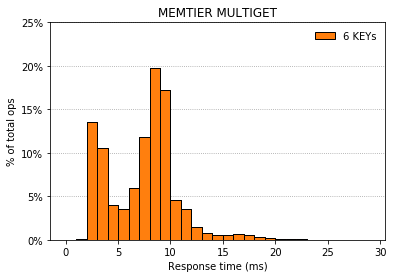

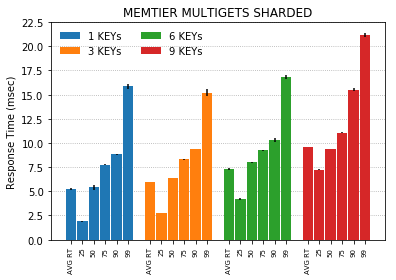

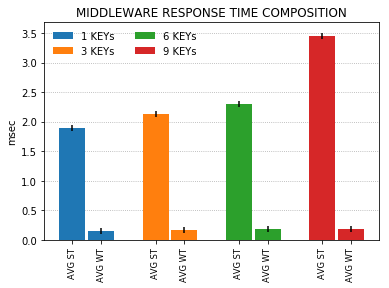

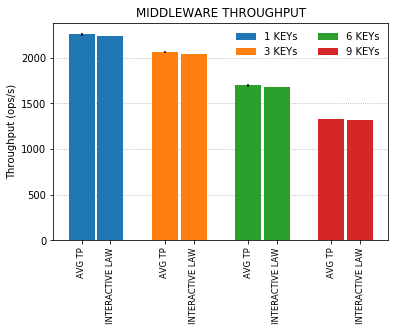

In [17]:
timestamp = '20181114183706'
log_dir = 'logs/%s/' % timestamp

logs = [f for f in listdir(log_dir) if fnmatch(f, '*.log')]

m = '^ratio(.*)'
memtier_logs = [f for f in logs if match(m, f)]
mw = '^stats(.*)'
middleware_logs = [f for f in logs if match(mw, f)]

ratios = ['1:1', '1:9', '1:18', '1:27']
runs = [x for x in range(1, 3 + 1)] 
instances = [x for x in range(1, 2 + 1)]
threads = 1 
clients = [x for x in range(1, 3 + 1)]
vclients = [2]
worker_threads = [64]
mws = [x for x in range(1, 2 + 1)]

mt_multi_index = [ratios, worker_threads, vclients, runs, clients, instances]
mw_multi_index = [ratios, worker_threads, vclients, runs, mws]

mt_len_index = len(ratios) * len(worker_threads) * len(vclients) * len(runs) * len(clients) * len(instances)
mw_len_index = len(ratios) * len(worker_threads) * len(vclients) * len(runs) * len(mws)

mt_names=['ratio', 'WTS', 'VCs', 'run', 'client', 'instance']
mw_names=['ratio', 'WTS', 'VCs', 'run', 'mw']

mt_index = pd.MultiIndex.from_product(mt_multi_index, names=mt_names)
mw_index = pd.MultiIndex.from_product(mw_multi_index, names=mw_names)

thresholds = [25, 50, 75, 90, 99]
columns = ['Throughput (ops/s)', 'ResponseTime (ms)']
columns = columns + [str(x) for x in thresholds]
pd.set_option("display.precision", 2)

mt_template = pd.DataFrame([[.0] * len(columns)] * mt_len_index, index=mt_index, columns=columns)
columns = ['Throughput (ops/s)', 'ResponseTime (ms)', 'Jobs', 'ServiceTime (ms)', 'WaitingTime (ms)', 'QueueSize']
mw_template = pd.DataFrame([[.0] * len(columns)] * mw_len_index, index=mw_index, columns=columns)

approx_rt = []

for log_file in memtier_logs: 

    ratio = get_ratio(log_file) 
    run = get_run(log_file)
    vcs = get_vcs(log_file)
    client = get_client(log_file)
    instance = get_instance(log_file)
    wts = get_worker_threads(log_file)

    table_offset = 0
    i=0
    
    avg_rt, avg_tp = parse_mt_content(log_dir, log_file)
    
    percentiles = np.percentile(avg_rt, thresholds)
    
    if ratio == '1:18':
        approx_rt.extend(avg_rt)
    
    mt_template.loc[(ratio, wts, vcs, run, client, instance), 'ResponseTime (ms)'] = np.mean(avg_rt)
    mt_template.loc[(ratio, wts, vcs, run, client, instance), 'Throughput (ops/s)'] = avg_tp
    
    for t, p in zip(thresholds, percentiles):
        mt_template.loc[(ratio, wts, vcs, run, client, instance), str(t)] = p
    
approx_rt.sort()
fig, ax = plt.subplots()
plt.rcParams["patch.force_edgecolor"] = True
plt.title("MEMTIER MULTIGET")
plt.xlabel("Response time (ms)")
plt.ylabel("% of total ops")

xs = approx_rt
ax.set_yticks(np.arange(0, 0.5, 0.05))
percent_formatter = lambda v, p: "{:d}%".format(int(v * 100.0))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(percent_formatter))


bin_size = 1.0
bins = [ 0 + i * bin_size for i in range(int(30/bin_size)) ]

ax.set_ylim(ymin=0, ymax=0.25)

ax.set_axisbelow(True)
plt.grid(b=True, which='major', axis='y', color='0.6', linestyle='dotted')

weights = np.ones_like(xs)/float(len(xs))
n, bins, patches = plt.hist(xs, bins=bins, weights=weights, histtype='bar', ec='black', linewidth=1)
plt.hist(xs, bins=bins, weights=weights, label="6 KEYs")
plt.legend(frameon=False)

fig.savefig('img/rt_distribution_memtier_multigets_sharded.png', bbox_inches='tight')

plt.rcParams["patch.force_edgecolor"] = False
rts, stds, ils = get_avg_rt(mt_template, ratios, worker_threads, vclients, runs, threads, len(instances), len(clients))

approx_rt = []
get_total = 0

for log_file in middleware_logs:
    ratio = get_ratio(log_file, True) 
    run = get_run(log_file, True)
    vcs = get_vcs(log_file, True)
    wts = get_worker_threads(log_file, True)
    mw = get_mw(log_file)
    
    with (open(log_dir+log_file, 'r')) as file:
        lines = file.readlines()

        offset = -1
        for i, line in enumerate(lines):
            if "Interval" in line:
                offset = i

        table = pd.read_table(log_dir+log_file, skiprows=1, engine='python', nrows=offset -1, skipinitialspace=True, sep=',\s*', index_col=0, names=['Elapsed Time', 'AVG Throughput', 'AVG Queue Size', 'AVG Waiting Time', 'AVG Service Time', 'AVG Response Time', 'AVG SET Response Time', 'AVG GET Response Time', 'AVG MULTI-GET Response Time', '#SETS', '#GETS', '#MULTIGETS', 'GET MissRatio', 'MULTI-GET MissRatio', 'AVG MULTI-GET Size'])
        table = table.astype('float32')
        
        sets = table['#SETS'].sum()
        gets = table['#GETS'].sum()
        multi = table['#MULTIGETS'].sum()
        
        mw_template.loc[(ratio, wts, vcs, run, mw), 'Throughput (ops/s)'] = table['AVG Throughput'].values[1:-1].mean()
        mw_template.loc[(ratio, wts, vcs, run, mw), 'ResponseTime (ms)'] = table['AVG Response Time'].values[1:-1].mean()
        
        if ratio[0] != '0':
            mw_template.loc[(ratio, wts, vcs, run, mw), 'Jobs'] += sets
        if ratio[-1] == '1':
            mw_template.loc[(ratio, wts, vcs, run, mw), 'Jobs'] += gets
        else:
            mw_template.loc[(ratio, wts, vcs, run, mw), 'Jobs'] += multi
        
        mw_template.loc[(ratio, wts, vcs, run, mw), 'ServiceTime (ms)'] = table['AVG Service Time'].values[1:-1].mean()
        mw_template.loc[(ratio, wts, vcs, run, mw), 'WaitingTime (ms)'] = table['AVG Waiting Time'].values[1:-1].mean()
        mw_template.loc[(ratio, wts, vcs, run, mw), 'QueueSize'] = table['AVG Queue Size'].values[1:-1].mean()
        
        get_total = gets + multi
    
    avg_rt = parse_mw_content(log_dir, log_file, get_total)

    if ratio == '1:18':
        approx_rt.extend(avg_rt)
        

ils = []
approx_rt.sort()
rts, stds, ils = get_avg_rt(mw_template, ratios, worker_threads, vclients, run, threads, len(instances), len(clients))
get_avg_st(mw_template, ratios, worker_threads, vclients, run, threads, len(instances), len(clients))
get_avg_tp(mw_template, ratios, worker_threads, vclients, run, ils, threads, len(instances), len(clients))

dump_csv(mt_template, 'out/memtier_data.csv')
dump_csv(mw_template, 'out/middleware_data.csv')


30


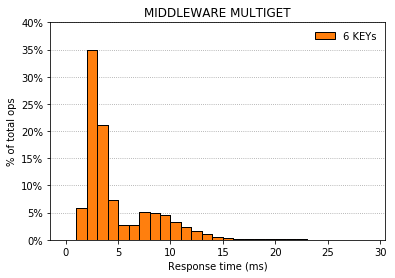

In [236]:
fig, ax = plt.subplots()
plt.rcParams["patch.force_edgecolor"] = True
plt.title("MIDDLEWARE MULTIGET")
plt.xlabel("Response time (ms)")
plt.ylabel("% of total ops")

xs = approx_rt
ax.set_yticks(np.arange(0, 0.7, 0.05))
percent_formatter = lambda v, p: "{:d}%".format(int(v * 100.0))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(percent_formatter))

bin_size = 1.0
bins = [ 0 + i * bin_size for i in range(int(30/bin_size)) ]

ax.set_ylim(ymin=0, ymax=0.4)

ax.set_axisbelow(True)
plt.grid(b=True, which='major', axis='y', color='0.6', linestyle='dotted')

weights = np.ones_like(xs)/float(len(xs))
n, bins, patches = plt.hist(xs, bins=bins, weights=weights, histtype='bar', ec='black', linewidth=1)
print(len(bins))
plt.hist(xs, bins=bins, weights=weights, label="6 KEYs")
plt.legend(frameon=False)

fig.savefig('img/rt_distribution_middleware_multigets_sharded.png', bbox_inches='tight')